In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps, quad
from astropy.table import Table
from astropy import units as u
from astropy.constants import G, h, c, k_B
from limbdark import Quad_interpolators, Claret_interpolators
from astropy.modeling import models
from astropy.modeling.blackbody import FLAM, blackbody_nu, blackbody_lambda
from scipy.optimize import leastsq
%matplotlib notebook

In [2]:
def get_limbdark_params(t1, g1, t2, g2, band):
    """
    Interpolates Gianninas table and returns limb-darkened params.

    Uses quadratic limb darkening law
    """
    Quad = dict()
    Claret = dict()
    Quad['ldc1_1'], Quad['ldc1_2'] = Quad_interpolators[band](t1, g1)
    Quad['ldc2_1'], Quad['ldc2_2'] = Quad_interpolators[band](t2, g2)

    Claret['ldc1_1'], Claret['ldc1_2'], Claret['ldc1_3'], Claret['ldc1_4'] = Claret_interpolators[band](t1,g1)
    Claret['ldc2_1'], Claret['ldc2_2'], Claret['ldc2_3'], Claret['ldc2_4'] = Claret_interpolators[band](t2,g2)
    return Quad, Claret

def claret(mu, c1, c2, c3, c4):
    return (1 - (c1 * (1 - mu**0.5)) - (c2 * (1 - mu))
            - (c3 * (1 - mu**1.5)) - (c4 * (1 - mu**2)))

def claret2(mu, c1, c2, c3, c4):
    return (1 - (c1 * (1 - mu**0.5)) - (c2 * (1 - mu))
            - (c3 * (1 - mu**1.5)) - (c4 * (1 - mu**2)))**2

def It_over_I1_Claret(T, logg, band):
    mu = np.linspace(0,1,100)
    c1, c2, c3, c4 = Claret_interpolators[band](T, logg)
    fRatio = simps(claret(mu, c1, c2, c3, c4), mu)
    return fRatio

def SDSSmagToFlux(mag):
    return 3631 * (u.Jansky) * 10**(-mag/2.5)

def Radius(mass, logg):
    M = mass * (u.M_sun)
    g = (10**logg) * (u.cm/u.s/u.s)
    R = np.sqrt(G * M / g).to(u.R_sun)
    return R

def It_over_I1_Claret(T, logg, band):
    mu = np.linspace(0,1,100)
    c1, c2, c3, c4 = Claret_interpolators[band](T, logg)
#     fRatio = simps(claret(mu, c1, c2, c3, c4), mu)
    fRatio = quad(claret,0,1,(c1,c2,c3,c4))[0]
    return fRatio

def planck(w, T):
    nu = (c / (w * u.AA)).to(u.Hz)
    B_nu = ((2 * h * nu**3) / c**2) / np.expm1( ((h * nu) / (k_B * T)))
    return B_nu.to(u.erg/u.cm/u.cm/u.s/u.Hz)

def BBresiduals(pars, wl, fl):
    (temp) = pars
    diff = np.abs((blackbody_nu(wl*u.AA,temperature=temp*u.K).value) - fl)
    return diff

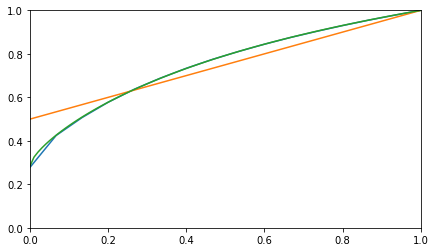

In [3]:
c1, c2, c3, c4 = Claret_interpolators['u'](10000,8.0)

dat = np.loadtxt('data/radial_bright_profiles.txt', skiprows=28, dtype='str')
data = dat[:,1:].astype('float')

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(np.linspace(0,1,16), data[440-29,2:])
ax.plot(np.linspace(0,1,100), 0.5*np.linspace(0,1,100) + 0.5)
ax.plot(np.linspace(0,1,100), claret(np.linspace(0,1,100), c1, c2, c3, c4))
ax.set_ylim([0,1])
ax.set_xlim([0,1])
plt.show()

In [4]:

bergeron = Table.read('data/Bergeron_DA2.txt', format='ascii')
bergeron.remove_columns(['U','B','V','R','I','Mbol','Age','BC','J','H','K','IR1','IR2','IR3','IR4','KG5'])
bergeron = bergeron[(bergeron['Teff'] >= 4000) & (bergeron['Teff'] <= 30000)]

I1_out = Table()
I1_out['Teff'] = bergeron['Teff']
I1_out['logg'] = bergeron['logg']

bands = ['u','g','r','i','z']
M = bergeron['M/Mo'] * (u.M_sun)
g = (10**bergeron['logg']) * (u.cm/u.s/u.s)
R = np.sqrt(G * M / g).to(u.R_sun)

I1_out['R/Ro'] = R
I1_out['R/Ro'].format = '.5f'
for filt in bands:
    bergeron['surf_flux_'+ filt] = (SDSSmagToFlux(bergeron[filt])
                                     * ( (10 * u.parsec)
                                        / (I1_out['R/Ro'].to(u.parsec)) )**2).to(u.erg/u.s/u.cm/u.cm/u.Hz)
    bergeron['surf_flux_'+ filt].format='1.3e'
ufil = []
gfil = []
rfil = []
ifil = []
zfil = []
for t, g in zip(bergeron['Teff'], bergeron['logg']):
    ufil.append(It_over_I1_Claret(t, g, 'u'))
for t, g in zip(bergeron['Teff'], bergeron['logg']):
    gfil.append(It_over_I1_Claret(t, g, 'g'))
for t, g in zip(bergeron['Teff'], bergeron['logg']):
    rfil.append(It_over_I1_Claret(t, g, 'r'))
for t, g in zip(bergeron['Teff'], bergeron['logg']):
    ifil.append(It_over_I1_Claret(t, g, 'i'))
for t, g in zip(bergeron['Teff'], bergeron['logg']):
    zfil.append(It_over_I1_Claret(t, g, 'z'))

I1_out['I1_u'] = bergeron['surf_flux_u'] / ufil
I1_out['I1_g'] = bergeron['surf_flux_g'] / gfil
I1_out['I1_r'] = bergeron['surf_flux_r'] / rfil
I1_out['I1_i'] = bergeron['surf_flux_i'] / ifil
I1_out['I1_z'] = bergeron['surf_flux_z'] / zfil

In [5]:
ugr = np.loadtxt('data/I_1_ugr.txt', dtype='str', usecols=[0,1,2,-1])
logg = ugr[:,1].astype('float')
teff = ugr[:,2].astype('float')
i1 = ugr[:,3].astype('float')

ugr_tab = Table()
ugr_tab['Teff'] = bergeron['Teff']
ugr_tab['logg'] = bergeron['logg']
ugr_tab_u = i1[(ugr[:,0] == 'u') & (logg >= 7.0) & ((logg % 1 == 0.5) | (logg % 1 == 0))]
ugr_tab_g = i1[(ugr[:,0] == 'g') & (logg >= 7.0) & ((logg % 1 == 0.5) | (logg % 1 == 0))]
ugr_tab_r = i1[(ugr[:,0] == 'r') & (logg >= 7.0) & ((logg % 1 == 0.5) | (logg % 1 == 0))]

ugr_tab['I1_u'] = ugr_tab_u
ugr_tab['I1_g'] = ugr_tab_g
ugr_tab['I1_r'] = ugr_tab_r
ugr_tab.show_in_notebook(display_length=5)

idx,Teff,logg,I1_u,I1_g,I1_r
0,4000.0,7.0,3.0978e-07,2.5985e-06,6.6347e-06
1,4250.0,7.0,5.4796e-07,3.654e-06,8.442e-06
2,4500.0,7.0,9.7594e-07,5.1918e-06,1.0865e-05
3,4750.0,7.0,1.7187e-06,7.3546e-06,1.3997e-05
4,5000.0,7.0,2.9554e-06,1.0214e-05,1.7792e-05
5,5250.0,7.0,4.905e-06,1.3755e-05,2.2095e-05
6,5500.0,7.0,7.6718e-06,1.8004e-05,2.6938e-05
7,6000.0,7.0,1.5323e-05,2.8614e-05,3.8129e-05
8,6500.0,7.0,2.5284e-05,4.1804e-05,5.113e-05
9,7000.0,7.0,3.7202e-05,5.7596e-05,6.5925e-05


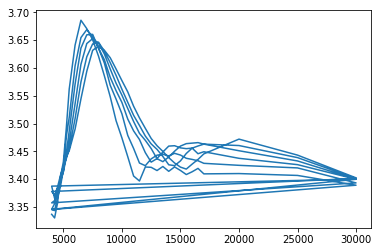

In [6]:
diff = Table()
diff['teff'] = I1_out['Teff']
diff['logg'] = I1_out['logg']
diff['u_factor'] = I1_out['I1_u'] / ugr_tab['I1_u']
diff['g_factor'] = I1_out['I1_g'] / ugr_tab['I1_g']
diff['r_factor'] = I1_out['I1_r'] / ugr_tab['I1_r']
# diff.show_in_notebook()
fig, ax = plt.subplots()
ax.plot(diff['teff'], diff['u_factor'])
plt.show()

In [7]:
bergeron.show_in_notebook(display_length=5)

idx,Teff,logg,M/Mo,u,g,r,i,z,surf_flux_u,surf_flux_g,surf_flux_r,surf_flux_i,surf_flux_z
,,,,,,,,,erg / (cm2 Hz s),erg / (cm2 Hz s),erg / (cm2 Hz s),erg / (cm2 Hz s),erg / (cm2 Hz s)
0,4000.0,7.0,0.155,18.38,15.993,14.865,14.429,14.187,7.473e-07,6.734e-06,1.903e-05,2.844e-05,3.554e-05
1,4250.0,7.0,0.157,17.734,15.599,14.591,14.199,13.984,1.338e-06,9.557e-06,2.418e-05,3.470e-05,4.230e-05
2,4500.0,7.0,0.159,17.078,15.193,14.302,13.958,13.776,2.417e-06,1.372e-05,3.116e-05,4.278e-05,5.058e-05
3,4750.0,7.0,0.162,16.432,14.784,14.005,13.708,13.559,4.300e-06,1.962e-05,4.021e-05,5.286e-05,6.063e-05
4,5000.0,7.0,0.168,15.804,14.39,13.714,13.46,13.342,7.394e-06,2.720e-05,5.069e-05,6.405e-05,7.140e-05
5,5250.0,7.0,0.174,15.212,14.027,13.444,13.229,13.139,1.232e-05,3.668e-05,6.276e-05,7.650e-05,8.311e-05
6,5500.0,7.0,0.179,14.693,13.704,13.202,13.023,12.958,1.931e-05,4.801e-05,7.624e-05,8.990e-05,9.545e-05
7,6000.0,7.0,0.188,13.898,13.167,12.796,12.678,12.656,3.823e-05,7.496e-05,1.055e-04,1.176e-04,1.200e-04
8,6500.0,7.0,0.192,13.325,12.734,12.462,12.394,12.409,6.346e-05,1.094e-04,1.405e-04,1.496e-04,1.475e-04


In [8]:
I1_out.show_in_notebook(display_length=5)

idx,Teff,logg,R/Ro,I1_u,I1_g,I1_r,I1_i,I1_z
,,,solRad,erg / (cm2 Hz s),erg / (cm2 Hz s),erg / (cm2 Hz s),erg / (cm2 Hz s),erg / (cm2 Hz s)
0,4000.0,7.0,0.02062,1.034e-06,8.472e-06,2.277e-05,3.311e-05,4.067e-05
1,4250.0,7.0,0.02075,1.825e-06,1.194e-05,2.880e-05,4.020e-05,4.816e-05
2,4500.0,7.0,0.02088,3.276e-06,1.708e-05,3.704e-05,4.947e-05,5.751e-05
3,4750.0,7.0,0.02108,5.850e-06,2.451e-05,4.794e-05,6.131e-05,6.913e-05
4,5000.0,7.0,0.02146,1.014e-05,3.420e-05,6.076e-05,7.465e-05,8.176e-05
5,5250.0,7.0,0.02184,1.713e-05,4.663e-05,7.586e-05,8.984e-05,9.583e-05
6,5500.0,7.0,0.02215,2.733e-05,6.207e-05,9.344e-05,1.068e-04,1.112e-04
7,6000.0,7.0,0.02270,5.579e-05,1.006e-04,1.334e-04,1.436e-04,1.433e-04
8,6500.0,7.0,0.02294,9.319e-05,1.491e-04,1.802e-04,1.850e-04,1.782e-04


In [58]:
wav = np.linspace(3000,10000,1000)*u.AA

In [59]:
filt_wav = [3594.93,4640.42,6122.33,7439.49,8897.06]

In [85]:
filts = dict()
filts['u']=0
filts['g']=1
filts['r']=2
filts['i']=3
filts['z']=4
band='z'
par_init=np.array([10000])
p = leastsq(BBresiduals, par_init, args=(filt_wav[filts[band]], fluxes[filts[band]]), full_output=True)[0]
print('T_BB = %.1f K' % p[0])

T_BB = 61940.3 K


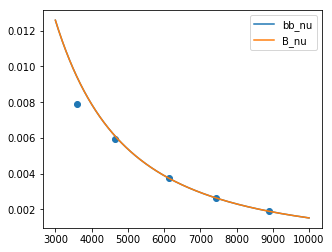

In [78]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(w, blackbody_nu(w*u.AA,temperature=p[0]*u.K).value, label='bb_nu')
ax.scatter(filt_wav,fluxes)
ax.legend()
plt.show()

In [147]:
WD2BB_Table = Table()
WD2BB_Table['Teff'] = I1_out['Teff']
WD2BB_Table['logg'] = I1_out['logg']
WD2BB_Table['T_BB_u'] = np.zeros(198)
WD2BB_Table['T_BB_g'] = np.zeros(198)
WD2BB_Table['T_BB_r'] = np.zeros(198)
WD2BB_Table['T_BB_i'] = np.zeros(198)
WD2BB_Table['T_BB_z'] = np.zeros(198)


filts = dict()
filts['u']=0
filts['g']=1
filts['r']=2
filts['i']=3
filts['z']=4

filt_wav = [3594.93,4640.42,6122.33,7439.49,8897.06]

par_init=np.array([10000])
for band in ['u','g','r','i','z']:
    for i in range(len(I1_out['Teff'])):
        flux = I1_out[i]['I1_' + band]
        p = leastsq(BBresiduals, par_init, args=(filt_wav[filts[band]], flux), full_output=True)[0]

        WD2BB_Table[i]['T_BB_' + band] = p

In [148]:
WD2BB_Table.write('data/Twd2Tbb.dat', format='ascii.tab')

In [149]:
WD2BB_Table.show_in_notebook(display_length=10)

idx,Teff,logg,T_BB_u,T_BB_g,T_BB_r,T_BB_i,T_BB_z
0,4000.0,7.0,4436.654486547816,5038.792342164918,5409.869304497316,5678.3027714733835,5990.983362458397
1,4250.0,7.0,4734.947009242891,5335.406216292509,5713.9140573631075,6007.965147668044,6360.166997949139
2,4500.0,7.0,5087.022361963424,5684.471706787665,6078.926830654652,6402.715771977334,6793.757396183107
3,4750.0,7.0,5491.502675113097,6085.471512435456,6502.53518382735,6863.5896992173575,7301.127951012015
4,5000.0,7.0,5939.369873348902,6507.796639527931,6944.276932584481,7342.974271600044,7824.421853308384
5,5250.0,7.0,6439.429330036288,6955.769025026408,7411.980796153093,7851.974571259815,8380.640767219942
6,5500.0,7.0,6961.470527253867,7426.131429375563,7907.674629876513,8387.693481588398,8966.662968496503
7,6000.0,7.0,7942.945102756521,8374.806179855572,8909.742062188692,9462.556520790711,10128.062017808565
8,6500.0,7.0,8834.919380743459,9338.156780241827,9952.310466854673,10585.439192062344,11334.137848336119
9,7000.0,7.0,9637.092344291908,10284.581523481202,10985.10860306568,11690.506396337263,12512.193077231657


30000.0 9.5


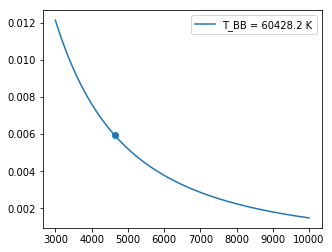

In [150]:
idx = 197
band = 'g'
print(WD2BB_Table[idx]['Teff'],WD2BB_Table[idx]['logg'])
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(w, blackbody_nu(w*u.AA,temperature=WD2BB_Table[idx]['T_BB_' + band]*u.K).value,
        label='T_BB = %.1f K' % WD2BB_Table[idx]['T_BB_' + band])
ax.scatter(filt_wav[filts[band]],I1_out[idx]['I1_' + band])
ax.legend()
plt.show()

In [152]:
importedtab = Table.read('Twd2Tbb.dat', format='ascii.tab')

In [164]:
importedtab.show_in_notebook()

idx,Teff,logg,T_BB_u,T_BB_g,T_BB_r,T_BB_i,T_BB_z
0,4000.0,7.0,4436.654486547816,5038.792342164918,5409.869304497316,5678.3027714733835,5990.983362458397
1,4250.0,7.0,4734.947009242891,5335.406216292509,5713.9140573631075,6007.965147668044,6360.166997949139
2,4500.0,7.0,5087.022361963424,5684.471706787665,6078.926830654652,6402.715771977334,6793.757396183107
3,4750.0,7.0,5491.502675113097,6085.471512435456,6502.53518382735,6863.5896992173575,7301.127951012015
4,5000.0,7.0,5939.369873348902,6507.796639527931,6944.276932584481,7342.974271600044,7824.421853308384
5,5250.0,7.0,6439.429330036288,6955.769025026408,7411.980796153093,7851.974571259815,8380.640767219942
6,5500.0,7.0,6961.470527253867,7426.131429375563,7907.674629876513,8387.693481588398,8966.662968496503
7,6000.0,7.0,7942.945102756521,8374.806179855572,8909.742062188692,9462.556520790711,10128.062017808565
8,6500.0,7.0,8834.919380743459,9338.156780241827,9952.310466854673,10585.439192062344,11334.137848336119
9,7000.0,7.0,9637.092344291908,10284.581523481202,10985.10860306568,11690.506396337263,12512.193077231657


In [154]:
from astropy.table import Table
# import pkg_resources
from scipy.interpolate import LinearNDInterpolator

bands = ('u', 'g', 'r', 'i', 'z')
blackbody_interpolators = dict()
filename = 'data/Twd2Tbb.dat'
# filename = pkg_resources.resource_filename('pylcurve', filename)
t = Table.read(filename, format='ascii.tab')

T = t['Teff']
G = t['logg']

for band in bands:
    temps = t['T_BB_' + band]

    coords_in = list(zip(T, G))
    Tbb_coords_out = list(temps)
    blackbody_interpolators[band] = LinearNDInterpolator(coords_in, Tbb_coords_out)

In [155]:
def wd_to_bb_temp(band, t, logg):
    t_bb = blackbody_interpolators[band](t, logg)
    return t_bb

In [163]:
print(wd_to_bb_temp('z', 14250, 9.5))

30236.484226136225


In [162]:
print((29784.45247475095 + 30688.5159775215) / 2)

30236.484226136225
